<a href="https://colab.research.google.com/github/manishbayesian/bayesianbookpub/blob/main/Chapter1_BayesCalculator%2C_Examples_X_XX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Chapter 1: Bayes Theorem & Examples X-XX. 
A simple calculator usingn Bayes' Theorem, and its applications as in Examples X through XX.

In [4]:
from scipy import special
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import random
import numpy as np

sns.set_theme(style="darkgrid")
pd.set_options()

In [129]:
class BayesCalculator:
  """
  Simple class that allows update of (posterior) based on
  """

  def __init__(self, hypotheses, prior=None):
      """Prints what the animals name is and what sound it makes.

        If the argument `sound` isn't passed in, the default Animal
        sound is used.

        Parameters
        ----------
        sound : str, optional
            The sound the animal makes (default is None)
        """
      if not prior:
        prior = np.ones(len(hypotheses))
      else:
        assert len(prior) == len(hypotheses), 'len(hypotheses) == len(prior)'
        prior = np.asarray(prior)
      prior = prior/sum(prior)
      self._bayes_df = pd.DataFrame(prior, index=hypotheses, columns=['prior'])
     
      self._bayes_df['likelihood'] = np.nan
      self._bayes_df['posterior'] = prior.copy()
      self._likelihoods = pd.DataFrame(index=hypotheses)

  def set_likelihood(self, data, likelihood):
      assert len(likelihood) == len(self._bayes_df.index), 'len(likelihood) == len(self.hypotheses)'
      self._likelihoods[data] = np.asarray(likelihood)
      return self

  def prior(self):
    return self._bayes_df['prior']

  def posterior(self):
    return self._bayes_df['posterior']

  def get_likelihood(self, data):
    return self._likelihoods[data]

  def likelihoods(self):
    return self._likelihoods

  def as_table(self):
    return self._bayes_df
  
  def update(self, data):
    unscaled_posterior = self._bayes_df['prior'] * self._likelihoods[data]
    self._bayes_df['likelihood'] = self._likelihoods[data] ## for display purposes, we store this
    self._bayes_df['posterior'] = unscaled_posterior/sum(unscaled_posterior)
    return self


In [126]:
def kw2dict(**kwargs):
    return kwargs

def plot_opts():
  return kw2dict(rot=0, xlabel='hypothesis')
  
def plot_prob_opts(prob_type):
  return kw2dict(title=prob_type.capitalize() , 
                  rot=0, ylabel=prob_type + ' probability', xlabel='hypothesis')
  
def plot_lik_opts(dat_name=None):
  tit_name = 'Likelihood for ' +  str(dat_name).capitalize() if dat_name else 'Likelihoods'
  return kw2dict(title=tit_name,
                 rot=0, ylabel='(relative) likelihood', xlabel='hypothesis')
     

In [146]:
## example usage
eyes = BayesCalculator(['blue','brown'],prior=[0.5,0.5]) \
        .set_likelihood('dark',[10,20]) \
        .set_likelihood('light',[15,7])


In [211]:
eyes = eyes.update('dark')
display(eyes.as_table())

,prior,likelihood,posterior
blue,0.5,10,0.333333
brown,0.5,20,0.666667


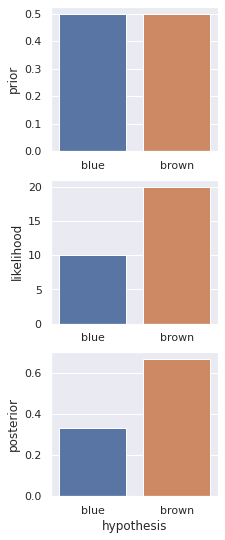

In [161]:
hyp = eyes.as_table().index
dat = eyes.as_table()
f, ax = plt.subplots(3,1,figsize=(3,9),)
sns.barplot(y='prior',     x=hyp,data=dat,ax=ax[0])
sns.barplot(y='likelihood',x=hyp,data=dat,ax=ax[1])
sns.barplot(y='posterior', x=hyp,data=dat,ax=ax[2]).set(xlabel='hypothesis')
plt.show()


In [179]:
## Covid Example.
# Use figures from https://pubmed.ncbi.nlm.nih.gov/34242764/
# Sensitivity of the rapid antigen test was 65.3% and the specificity was 99.9% 
## Here let's use fictitious numbers of specificity=97.5, sensitivity=94.3

covid_test = BayesCalculator(['not infected','infected'],prior=[0.95,0.05])

## Likelihoods (for -ve test) are specifity, 1- sensitivity
## Likelihoods (for +ve test) are 1-specificity, sensitivity
covid_test = covid_test \
            .set_likelihood('Negative',[97.5,5.7]) \
            .set_likelihood('Positive',[2.5, 94.3])

In [180]:
covid_test = covid_test.update('Positive')
display(covid_test.as_table())

,prior,likelihood,posterior
not infected,0.95,2.5,0.334979
infected,0.05,94.3,0.665021


In [182]:
covid_test.posterior()['infected']

0.6650211565585331

In [188]:
sensitivity = 0.943
specificity = 0.957
prevalence = np.linspace(0,1.,100)
infected_prob_pos = []
infected_prob_neg = []
for p in prevalence:
  test = BayesCalculator(['NI','I'],prior=[1-p,p]) \
          .set_likelihood('-',[specificity,    1.-sensitivity]) \
          .set_likelihood('+',[1.-specificity, sensitivity])
  test = test.update('+')
  infected_prob_pos.append(test.update('+').posterior()['I'])
  infected_prob_neg.append(test.update('-').posterior()['I'])


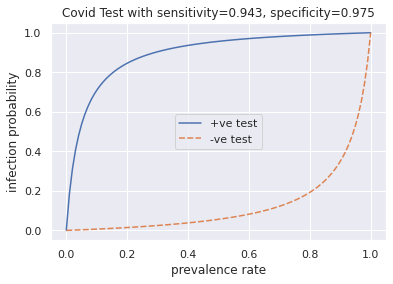

In [199]:
infected_prob = pd.DataFrame({'+ve test':infected_prob_pos, '-ve test':infected_prob_neg},index=prevalence)
sns.lineplot(data=infected_prob).set(xlabel='prevalence rate',
                                     ylabel='infection probability',
                                     title='Covid Test with sensitivity=0.943, specificity=0.975')
plt.show()

In [209]:
ss_values = np.linspace(0,1.,100)
covid_rate_sens = []
ss = np.linspace(0,1.,100)
covid_rate_sens = []
covid_rate_spec = []

for s in ss_values:
  specificity = 0.95
  sensitivity = s
  test = BayesCalculator(['NI','I'],prior=[0.95,0.05]) \
          .set_likelihood('-',[specificity,    1.-sensitivity]) \
          .set_likelihood('+',[1.-specificity, sensitivity])
  covid_rate_sens.append(test.update('+').posterior()['I'])

for s in ss_values:
  specificity = s
  sensitivity = 0.95
  test = BayesCalculator(['NI','I'],prior=[0.95,0.05]) \
          .set_likelihood('-',[specificity,    1.-sensitivity]) \
          .set_likelihood('+',[1.-specificity, sensitivity])
  covid_rate_spec.append(test.update('+').posterior()['I'])

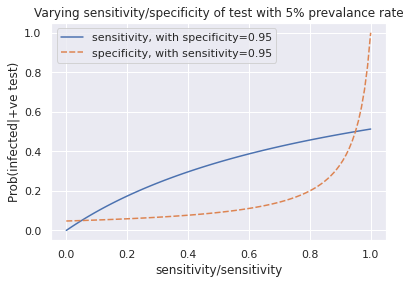

In [210]:
infected_prob = pd.DataFrame({'sensitivity, with specificity=0.95':covid_rate_sens, 
                              'specificity, with sensitivity=0.95':covid_rate_spec},
                              index=ss_values)
sns.lineplot(data=infected_prob).set(xlabel='sensitivity/sensitivity',
                                     ylabel='Prob(infected|+ve test)',
                                     title='Varying sensitivity/specificity of test with 5% prevalance rate')
plt.show()

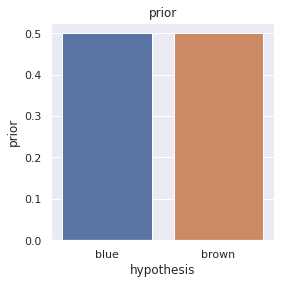

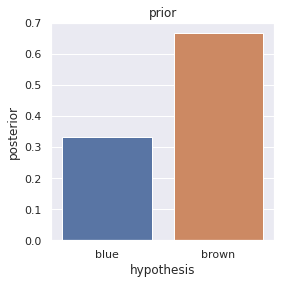

In [148]:
plt.figure(figsize=(4,4))
sns.barplot(y='prior',x=eyes.as_table().index,data=eyes.as_table()).set(title='prior',xlabel='hypothesis')
plt.show()
plt.figure(figsize=(4,4))
sns.barplot(y='posterior',x=eyes.as_table().index,data=eyes.as_table()).set(title='prior',xlabel='hypothesis')
plt.show()


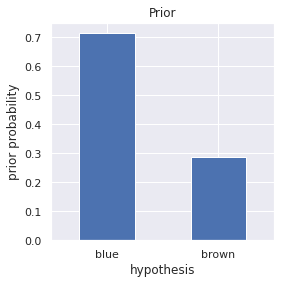

In [116]:
eyes.prior().plot.bar(figsize=(4,4),**plot_prob_opts('prior'))
plt.show()

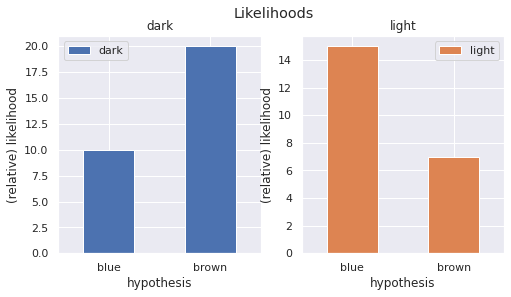

In [117]:
eyes.likelihoods().plot.bar(subplots=True, layout=(1,2), figsize=(8,4),**plot_lik_opts())
plt.show()

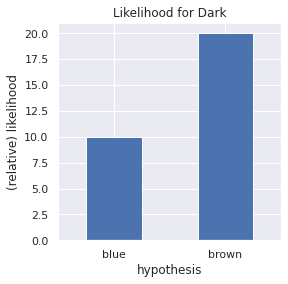

In [118]:
eyes.get_likelihood('dark').plot.bar(figsize=(4,4),**plot_lik_opts('dark'))
plt.show()

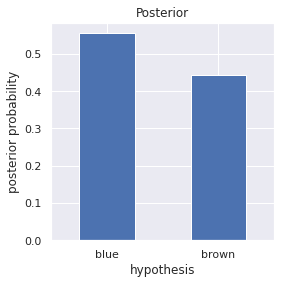

In [119]:
eyes.update('dark').posterior().plot.bar(figsize=(4,4),**plot_prob_opts('posterior'))
plt.show()

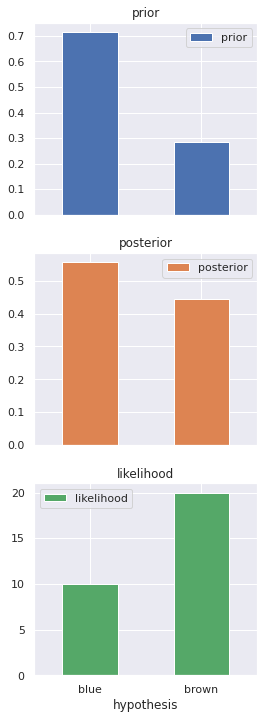

In [123]:
eyes._bayes_df.plot.bar(subplots=True, figsize=(4,12), **plot_opts())
plt.show()

In [ ]:
# probability of hash collision (for a single byte hash) after n random operations
def no_collision_prob(n, HASHLEN=256):
  return special.perm(HASHLEN,n)/(HASHLEN**n)


In [ ]:
## plot probability of hash collision with operations
hashcols = {n:1.-no_collision_prob(n) for n in range(100)}

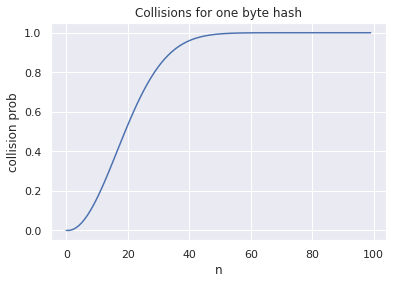

In [ ]:
sns.lineplot(data=pd.DataFrame({'n':hashcols.keys(),'collision prob': hashcols.values()}), 
             x='n',y='collision prob').set(title='Collisions for one byte hash')
plt.show()

#### The Famous Birthday "Paradox".
_If you are in a room with N people, what is the probability that at least two people have the same birthday?_ 

The hash collision example above is a variation of this apparent "paradox" because it takes N=23 for this collision probability to exceed 0.5, which is counterintuitive to a possible (incorrect) intuition that this value would be 365/2. 

In [ ]:
birthday_probs = {n:1.-no_collision_prob(n,365) for n in range(100)}

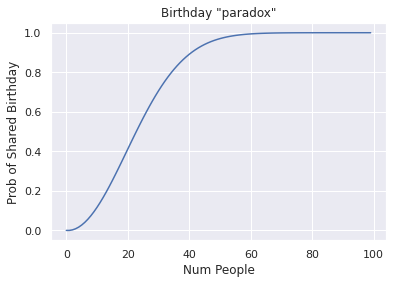

In [ ]:
sns.lineplot(data=pd.DataFrame({'Num People':birthday_probs.keys(),'Prob of Shared Birthday': birthday_probs.values()}), 
             x='Num People',y='Prob of Shared Birthday').set(title='Birthday "paradox"')
plt.show()

### Simulation ("Frequentist") Approach to the Hash Collision Problem
Using a simulation method using 10000 trials gives us a similar result to the analytic solution above.


In [ ]:
N_TRIALS=10000

def estimate_collision_prob(n, HASHLEN=256):
  num_colls = 0
  for t in range(N_TRIALS):
    hashes = random.randint(1,HASHLEN, size=n)
    if len(set(hashes)) < n:
      num_colls += 1
  return 1.*num_colls/N_TRIALS




In [ ]:
sim_hashcols = {n:estimate_collision_prob(n) for n in range(100)}

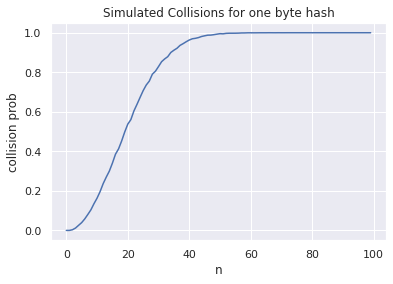

In [ ]:
sns.lineplot(data=pd.DataFrame({'n':sim_hashcols.keys(),'collision prob': sim_hashcols.values()}), 
             x='n',y='collision prob').set(title='Simulated Collisions for one byte hash')
plt.show()